<a href="https://colab.research.google.com/github/zli873/STAT-628-Module3/blob/master/NMF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Preprocessing

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In this notebook we will look at the steps involved in preprocessing a corpus of unstructed text documents using *scikit-learn*, which we will use later for topic modelling.

### Loading the Documents

As our sample corpus of text, we will use a corpus of news articles collected in 2016. These articles have been stored in a single file and formatted so that one article appears on each line. We will load these articles into a list, and also create a short snippet of text for each document.

In [0]:
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/628 module3/bars/bars_review.csv',nrows=50000)


### Creating a Document-Term Matrix

When preprocessing text, a common approach is to remove non-informative stopwords. The choice of stopwords can have a considerable impact later on. We will use a custom stopword list:

In the *bag-of-words model*, each document is represented by a vector in a *m*-dimensional coordinate space, where *m* is number of unique terms across all documents. This set of terms is called the corpus *vocabulary*. 

Since each document can be represented as a term vector, we can stack these vectors to create a full *document-term matrix*. We can easily create this matrix from a list of document strings using *CountVectorizer* from Scikit-learn. The parameters passed to *CountVectorizer* control the pre-processing steps that it performs.

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
# use a custom stopwords list, set the minimum term-document frequency to 20
vectorizer = CountVectorizer(stop_words = 'english', min_df = 20)
A = vectorizer.fit_transform(raw_documents)
print( "Created %d X %d document-term matrix" % (A.shape[0], A.shape[1]) )

Created 10000 X 2702 document-term matrix


This process also builds a vocabulary for the corpus:

In [0]:
terms = vectorizer.get_feature_names()
print("Vocabulary has %d distinct terms" % len(terms))

Vocabulary has 2702 distinct terms


We can save this document-term matrix, terms, and snippets for later use using *Joblib* to persist the data.

In [0]:
from sklearn.externals import joblib
joblib.dump((A,terms,raw_documents), "articles-raw.pkl") 

['articles-raw.pkl']

### Applying Term Weighting with TF-IDF

We can improve the usefulness of the document-term matrix by giving more weight to the more "important" terms. The most common normalisation is *term frequency–inverse document frequency* (TF-IDF). In Scikit-learn, we can generate at TF-IDF weighted document-term matrix by using *TfidfVectorizer* in place of *CountVectorizer*.

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
# we can pass in the same preprocessing parameters
# Load the regular expression library
import re
raw_documents = df.text
# Remove punctuation
raw_documents = raw_documents.map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
raw_documents = raw_documents.map(lambda x: x.lower())
# Print out the first rows of papers
raw_documents.head()

vectorizer = TfidfVectorizer(stop_words='english', min_df = 20)
A = vectorizer.fit_transform(raw_documents)
print( "Created %d X %d TF-IDF-normalized document-term matrix" % (A.shape[0], A.shape[1]) )

Created 50000 X 6948 TF-IDF-normalized document-term matrix


In [0]:
# extract the resulting vocabulary
terms = vectorizer.get_feature_names()
print("Vocabulary has %d distinct terms" % len(terms))

Vocabulary has 6948 distinct terms


A simple characterisation that we might do would be to look at the terms with the highest TF-IDF scores across all documents in the document-term matrix. We can define such a function as follows:

In [0]:
import operator
def rank_terms( A, terms ):
    # get the sums over each column
    sums = A.sum(axis=0)
    # map weights to the terms
    weights = {}
    for col, term in enumerate(terms):
        weights[term] = sums[0,col]
    # rank the terms by their weight over all documents
    return sorted(weights.items(), key=operator.itemgetter(1), reverse=True)

We can now display a ranking of the top 20 terms, which gives us a very rough sense of the content of the document collection:

In [0]:
ranking = rank_terms( A, terms )
for i, pair in enumerate( ranking[0:20] ):
    print( "%02d. %s (%.2f)" % ( i+1, pair[0], pair[1] ) )

01. food (2048.95)
02. great (1987.30)
03. good (1830.13)
04. place (1696.34)
05. service (1499.96)
06. time (1084.25)
07. bar (1020.74)
08. like (1009.32)
09. just (1001.47)
10. really (947.67)
11. nice (858.81)
12. best (811.02)
13. amazing (806.42)
14. drinks (797.61)
15. restaurant (789.42)
16. love (783.57)
17. ordered (762.02)
18. menu (759.60)
19. staff (745.17)
20. delicious (731.61)


Again we will save this document-term matrix, terms, and snippets for topic modelling later using *Joblib*.

In [0]:
joblib.dump((A,terms,raw_documents), "articles-tfidf.pkl") 

['articles-tfidf.pkl']

In [0]:
from sklearn.externals import joblib
(A,terms,snippets) = joblib.load( "articles-tfidf.pkl" )
print( "Loaded %d X %d document-term matrix" % (A.shape[0], A.shape[1]) )

Loaded 50000 X 6948 document-term matrix


In [0]:
k = 10

In [0]:
# create the model
from sklearn import decomposition
model = decomposition.NMF( init="nndsvd", n_components=k ) 
# apply the model and extract the two factor matrices
W = model.fit_transform( A )
H = model.components_

In [0]:
W.shape

(50000, 10)

In [0]:
W[0,:].round(2)

array([0.  , 0.02, 0.  , 0.02, 0.  , 0.  , 0.  , 0.03, 0.01, 0.05])

In [0]:
term_index = terms.index('beer')
# round to 2 decimal places for display purposes
H[:,term_index].round(2)

array([0.  , 0.  , 1.59, 0.  , 0.  , 0.07, 0.  , 0.  , 0.  , 0.  ])

In [0]:
import numpy as np
def get_descriptor( terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
    return top_terms

In [0]:
descriptors = []
for topic_index in range(k):
    descriptors.append( get_descriptor( terms, H, topic_index, 10 ) )
    str_descriptor = ", ".join( descriptors[topic_index] )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: minutes, time, table, came, order, server, took, asked, just, got
Topic 02: great, atmosphere, awesome, staff, time, friendly, drinks, spot, wine, patio
Topic 03: bar, beer, selection, beers, nice, area, friendly, bartender, drink, like
Topic 04: good, really, pretty, nice, atmosphere, time, food, overall, prices, drinks
Topic 05: food, service, excellent, slow, restaurant, better, quality, customer, mexican, price
Topic 06: burger, fries, cheese, mac, burgers, wings, bacon, guy, sandwich, ordered
Topic 07: place, love, fun, like, drinks, friends, just, awesome, cool, people
Topic 08: happy, hour, tacos, specials, menu, prices, drinks, margaritas, dog, margarita
Topic 09: amazing, best, vegas, staff, ve, friendly, definitely, recommend, time, highly
Topic 10: chicken, salad, ordered, menu, steak, sauce, delicious, like, restaurant, cheese


In [0]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

In [0]:
def plot_top_term_weights( terms, H, topic_index, top ):
    # get the top terms and their weights
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    top_weights = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
        top_weights.append( H[topic_index,term_index] )
    # note we reverse the ordering for the plot
    top_terms.reverse()
    top_weights.reverse()
    # create the plot
    fig = plt.figure(figsize=(13,8))
    # add the horizontal bar chart
    ypos = np.arange(top)
    ax = plt.barh(ypos, top_weights, align="center", color="green",tick_label=top_terms)
    plt.xlabel("Term Weight",fontsize=14)
    plt.tight_layout()
    plt.show()

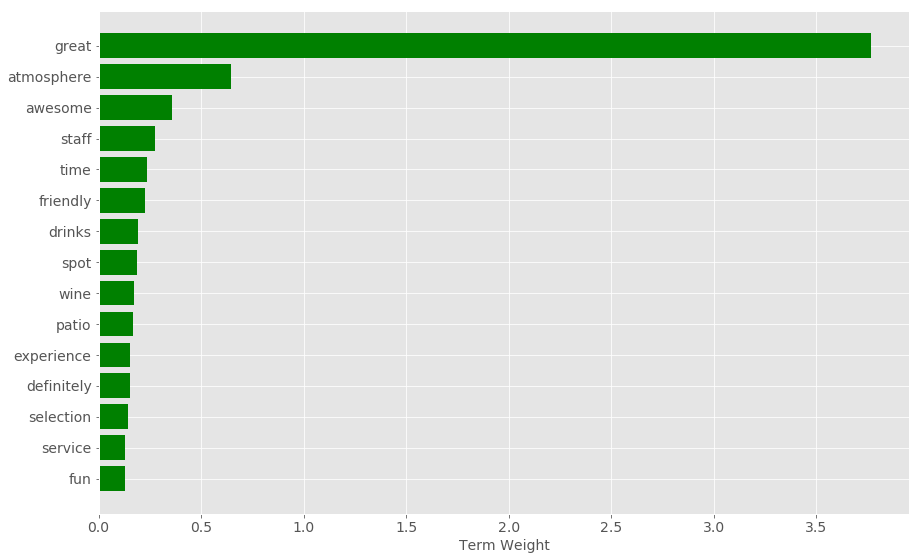

In [0]:
plot_top_term_weights( terms, H, 1, 15 )

In [0]:
def get_top_snippets( all_snippets, W, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( W[:,topic_index] )[::-1]
    # now get the snippets corresponding to the top-ranked indices
    top_snippets = []
    for doc_index in top_indices[0:top]:
        top_snippets.append( all_snippets[doc_index] )
    return top_snippets
topic_snippets = get_top_snippets( raw_documents, W, 0, 10 )
for i, snippet in enumerate(topic_snippets):
    print("%02d. %s" % ( (i+1), raw_documents ) )

01. 0        went in for a lunch steak sandwich was delicio...
1        walked in around 4 on a friday afternoon we sa...
2        went here last weekend and was pretty disappoi...
3        this place epitomizes the rumored transformati...
4        i've never experienced discrimination as i did...
5        we had dinner here and the food was excellent ...
6        this random hole in the wall is located in the...
7        th service here is very hit or miss sometimes ...
8        heard about this place and was dying to check ...
9        received a  mailer and thought okay let's go w...
10       first off food is delicious by far my favorite...
11       wonderful experience we sat outside on the pat...
12       beer beer and more beer  it's definitely a low...
13       love the crust on this pizza the sauce is dece...
14       i'm not that familiar with scottsdale so i'm j...
15       "good morning cocktails for you" \nwaitwhat oh...
16       hands down best bloody mary ever so many th

In [0]:
joblib.dump((W,H,terms,snippets), "articles-model-nmf-k%02d.pkl" % k)

['articles-model-nmf-k10.pkl']

In [0]:
from sklearn.externals import joblib
(A,terms,snippets) = joblib.load( "articles-tfidf.pkl" )
print( "Loaded %d X %d document-term matrix" % (A.shape[0], A.shape[1]) )

Loaded 50000 X 6948 document-term matrix


In [0]:
kmin, kmax = 4, 15

In [0]:
from sklearn import decomposition
topic_models = []
# try each value of k
for k in range(kmin,kmax+1):
    print("Applying NMF for k=%d ..." % k )
    # run NMF
    model = decomposition.NMF( init="nndsvd", n_components=k ) 
    W = model.fit_transform( A )
    H = model.components_    
    # store for later
    topic_models.append( (k,W,H) )

Applying NMF for k=4 ...
Applying NMF for k=5 ...
Applying NMF for k=6 ...
Applying NMF for k=7 ...
Applying NMF for k=8 ...
Applying NMF for k=9 ...
Applying NMF for k=10 ...
Applying NMF for k=11 ...
Applying NMF for k=12 ...
Applying NMF for k=13 ...
Applying NMF for k=14 ...
Applying NMF for k=15 ...


In [0]:
import re
class TokenGenerator:
    def __init__( self, documents, stopwords ):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile( r"(?u)\b\w\w+\b" )

    def __iter__( self ):
        print("Building Word2Vec model ...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall( doc ):
                if tok in self.stopwords:
                    tokens.append( "<stopword>" )
                elif len(tok) >= 2:
                    tokens.append( tok )
            yield tokens

In [0]:
import gensim
docgen = TokenGenerator( raw_documents, 'english')
# the model has 500 dimensions, the minimum document-term frequency is 20
w2v_model = gensim.models.Word2Vec(docgen, size=500, min_count=20, sg=1)

Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...


In [0]:
print( "Model has %d terms" % len(w2v_model.wv.vocab) )

Model has 7513 terms


In [0]:
w2v_model.save("w2v-model.bin")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( w2v_model.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

In [0]:
import numpy as np
def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

In [0]:
from itertools import combinations
k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  import sys
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


K=04: Coherence=0.2739
K=05: Coherence=0.2766
K=06: Coherence=0.2760
K=07: Coherence=0.2627
K=08: Coherence=0.2606
K=09: Coherence=0.2721
K=10: Coherence=0.2670
K=11: Coherence=0.2604
K=12: Coherence=0.2635
K=13: Coherence=0.2620
K=14: Coherence=0.2612
K=15: Coherence=0.2641


In [0]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

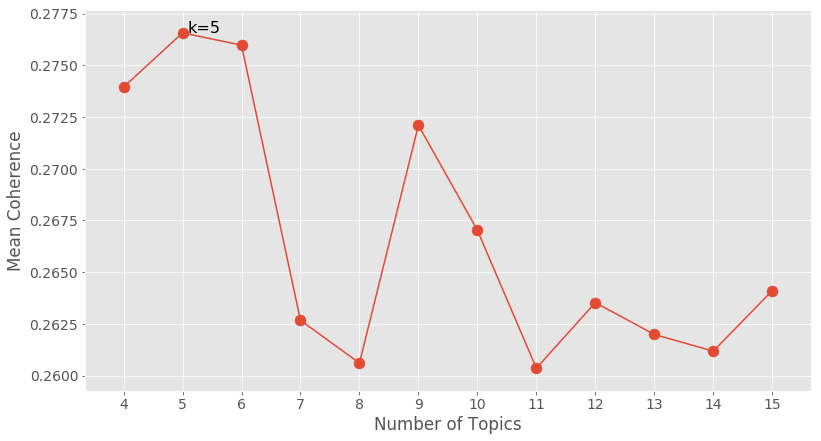

In [0]:
fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter( k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()

In [0]:
k = best_k
# get the model that we generated earlier.
W = topic_models[k-kmin][1]
H = topic_models[k-kmin][2]

In [0]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10 )
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: minutes, time, table, food, came, order, server, service, took, asked
Topic 02: great, food, service, amazing, atmosphere, awesome, staff, friendly, place, best
Topic 03: place, bar, beer, love, like, fun, drinks, night, nice, music
Topic 04: chicken, burger, cheese, ordered, fries, salad, delicious, sauce, menu, steak
Topic 05: good, food, really, service, pretty, nice, prices, price, atmosphere, decent
